In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [3]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [4]:
def build_vgg19_unet(input_shape, num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [5]:
input_shape = (256, 256, 3)
model = build_vgg19_unet(input_shape,4)
model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                       

# Training

In [6]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from sklearn.model_selection import train_test_split


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
drive_path = '/content/drive/MyDrive/PFA' 

In [9]:
H = 256
W = 256

def create_dir(path):
    """Create a directory"""
    if not os.path.exists(path):
        os.mkdir(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path, split=0.2):

    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/label/*.bmp"))
    
    print(len(masks), len(images))

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)
    print(len(train_x), len(train_y), len(valid_x), len(valid_y))
   
    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode('utf-8')
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x[x == 255] = 0
    x[x == 223] = 1 #ZP
    x[x == 127] = 2 #TE
    x[x == 191] = 3 #ICM
    x[ x > 3] = 0
    x = x.astype(np.int32)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.int32])
    y = tf.one_hot(y, 4, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 4])

    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)

    return dataset

In [10]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [11]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing files"""
create_dir("/content/drive/MyDrive/PFA/files_vgg19")

"""Hyperparameters"""
batch_size = 10
learning_rate = 1e-4
num_epochs = 30
model_path = os.path.join("/content/drive/MyDrive/PFA/files_vgg19", "model.h5")
csv_path = os.path.join("/content/drive/MyDrive/PFA/files_vgg19", "data.csv")

"""Dataset"""
dataset_path = os.path.join("/content/drive/MyDrive/PFA/new_data")
train_path = os.path.join(dataset_path, "train")

(train_x, train_y), (valid_x, valid_y) = load_data(train_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

"""Model"""

model = build_vgg19_unet((H, W, 3),4)
metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=metrics)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=test_dataset,
    validation_steps=valid_steps,
    callbacks=callbacks
)


945 945
756 756 189 189
Train: 756 - 756
Valid: 189 - 189
Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.6955 - dice_coef: 0.5932 - iou: 0.4339 - accuracy: 0.7710 - recall: 0.6579 - precision: 0.8535
Epoch 1: val_loss improved from inf to 2.49642, saving model to /content/drive/MyDrive/PFA/files_vgg19/model.h5
75/75 [==============================] - 246s 3s/step - loss: 0.6955 - dice_coef: 0.5932 - iou: 0.4339 - accuracy: 0.7710 - recall: 0.6579 - precision: 0.8535 - val_loss: 2.4964 - val_dice_coef: 0.3873 - val_iou: 0.2404 - val_accuracy: 0.4081 - val_recall: 0.3489 - val_precision: 0.4112 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.3458 - dice_coef: 0.7862 - iou: 0.6481 - accuracy: 0.8923 - recall: 0.8714 - precision: 0.9088
Epoch 2: val_loss improved from 2.49642 to 0.99374, saving model to /content/drive/MyDrive/PFA/files_vgg19/model.h5
75/75 [==============================] - 116s 1s/step - loss: 0.3458 - dice_coe

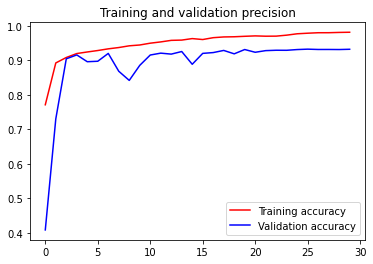

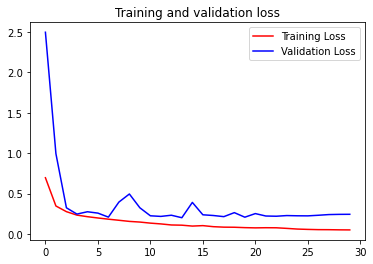

In [12]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [13]:
def load_data(path):

    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/label/*.bmp"))
    
    print(len(images), len(masks))
   
    return (images, masks)

In [14]:
test_path = os.path.join(dataset_path, "test")
(test_x, test_y) = load_data(test_path)

48 48


In [15]:
from tqdm import tqdm

In [16]:
num_classes = 4

In [17]:
res_path = os.path.join(dataset_path, "results_vgg19")
create_dir(res_path)
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ## Read image
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = x / 255.0
        x = x.astype(np.float32)

        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y[y == 255] = 0
        y[y == 223] = 1 #ZP
        y[y == 127] = 2 #TE
        y[y == 191] = 3 #ICM
        y[ y > 3] = 0
        y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        y = y * (255/num_classes)
        y = y.astype(np.int32)
        y = np.concatenate([y, y, y], axis=2)

        ## Prediction
        p = model.predict(np.expand_dims(x, axis=0))[0]
        p = np.argmax(p, axis=-1)
        p = np.expand_dims(p, axis=-1)
        p = p * (255/num_classes)
        p = p.astype(np.int32)
        p = np.concatenate([p, p, p], axis=2)

        x = x * 255.0
        x = x.astype(np.int32)

        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        print(x.shape, line.shape, y.shape, line.shape, p.shape)

        final_image = np.concatenate([x, line, y, line, p], axis=1)
        status = cv2.imwrite(f"{res_path}/{name}", final_image)
        print(status)
        

  2%|▏         | 1/48 [00:02<02:19,  2.97s/it]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


  4%|▍         | 2/48 [00:03<01:10,  1.53s/it]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


  6%|▋         | 3/48 [00:04<00:51,  1.14s/it]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


  8%|▊         | 4/48 [00:04<00:40,  1.10it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 10%|█         | 5/48 [00:05<00:35,  1.21it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 12%|█▎        | 6/48 [00:06<00:31,  1.32it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 15%|█▍        | 7/48 [00:06<00:29,  1.39it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 17%|█▋        | 8/48 [00:07<00:29,  1.38it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 19%|█▉        | 9/48 [00:07<00:26,  1.50it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 21%|██        | 10/48 [00:08<00:25,  1.47it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 23%|██▎       | 11/48 [00:09<00:25,  1.43it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 25%|██▌       | 12/48 [00:10<00:24,  1.49it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 27%|██▋       | 13/48 [00:10<00:22,  1.58it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 29%|██▉       | 14/48 [00:11<00:21,  1.58it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 31%|███▏      | 15/48 [00:11<00:20,  1.58it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 33%|███▎      | 16/48 [00:12<00:19,  1.63it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 35%|███▌      | 17/48 [00:12<00:18,  1.65it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 38%|███▊      | 18/48 [00:14<00:23,  1.27it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 40%|███▉      | 19/48 [00:15<00:24,  1.19it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 42%|████▏     | 20/48 [00:15<00:21,  1.29it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 44%|████▍     | 21/48 [00:16<00:21,  1.27it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 46%|████▌     | 22/48 [00:17<00:19,  1.36it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 48%|████▊     | 23/48 [00:17<00:17,  1.47it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 50%|█████     | 24/48 [00:18<00:16,  1.50it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 52%|█████▏    | 25/48 [00:18<00:14,  1.56it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 54%|█████▍    | 26/48 [00:19<00:14,  1.52it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 56%|█████▋    | 27/48 [00:20<00:14,  1.47it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 58%|█████▊    | 28/48 [00:20<00:13,  1.52it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 60%|██████    | 29/48 [00:21<00:12,  1.56it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 62%|██████▎   | 30/48 [00:22<00:11,  1.55it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 65%|██████▍   | 31/48 [00:23<00:12,  1.39it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 67%|██████▋   | 32/48 [00:23<00:10,  1.51it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 69%|██████▉   | 33/48 [00:24<00:09,  1.58it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 71%|███████   | 34/48 [00:24<00:08,  1.59it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 73%|███████▎  | 35/48 [00:25<00:08,  1.58it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 75%|███████▌  | 36/48 [00:26<00:07,  1.64it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 77%|███████▋  | 37/48 [00:26<00:06,  1.62it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 79%|███████▉  | 38/48 [00:27<00:06,  1.61it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 81%|████████▏ | 39/48 [00:27<00:05,  1.67it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 83%|████████▎ | 40/48 [00:28<00:04,  1.64it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 85%|████████▌ | 41/48 [00:29<00:04,  1.64it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 88%|████████▊ | 42/48 [00:30<00:04,  1.41it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 90%|████████▉ | 43/48 [00:30<00:03,  1.46it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 92%|█████████▏| 44/48 [00:31<00:02,  1.58it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 94%|█████████▍| 45/48 [00:31<00:01,  1.57it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 96%|█████████▌| 46/48 [00:32<00:01,  1.51it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


 98%|█████████▊| 47/48 [00:33<00:00,  1.51it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True


100%|██████████| 48/48 [00:33<00:00,  1.42it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
